# LunarLander-v3 feat. Reinforcemente Learning 🚀

By
- Miguel González
- Javier Quesada

## Info

### Documentación

Problemas interesantes para Aprendizaje por refuerzo
 * Gymnasium: https://gymnasium.farama.org/environments/box2d/

### Instalación

%pip install gymnasium  
%pip install gymnasium[box2d] 

### Acciones adicionales

Pueden ser necesarias *antes* de instalar gymnasium[box2d].

#### En macos

pip uninstall swig  
xcode-select -—install (instala las herramientas de desarrollador si no se tienen ya)  
pip install swig  / sudo port install swig-python
pip install 'gymnasium[box2d]' # en zsh hay que poner las comillas  

#### en Windows

Si da error, se debe a la falta de la versión correcta de Microsoft C++ Build Tools, que es una dependencia de Box2D. Para solucionar este problema, puede seguir los siguientes pasos:
 * Descargar Microsoft C++ Build Tools desde https://visualstudio.microsoft.com/visual-cpp-build-tools/.
 * Dentro del instalador, seleccione la opción "Desarrollo para el escritorio con C++"
 * Reinicie su sesión en Jupyter Notebook o en Visual Studio.
 * Ejecute nuevamente el comando !pip install gymnasium[box2d] en la línea de comandos de su notebook.

#### En linux (colab)
  * pip install swig

## Dependencias 📦

In [ ]:
%pip install swig -q
%pip install gymnasium[box2d] -q
%pip install loky -q

In [2]:
import gymnasium as gym
from gymnasium.wrappers import RecordVideo
import numpy as np
import pygame
import gymnasium.utils.play
from MLP import MLP
import copy
from loky import get_reusable_executor
import random
import matplotlib.pyplot as plt

## AutoPlay - humano 🕹️

In [12]:
# prueba lunar lander por humano
env_human = gym.make("LunarLander-v3", render_mode="rgb_array")

lunar_lander_keys = {
    (pygame.K_UP,): 2,
    (pygame.K_LEFT,): 1,
    (pygame.K_RIGHT,): 3,
}
gymnasium.utils.play.play(env_human, zoom=1, keys_to_action=lunar_lander_keys, noop=0)

## Desarrollo de funciones 🧩

### Modelo 🧠

In [3]:
# construir modelo
LAYERS = [8, 6, 4]
model =  MLP(LAYERS)

### Política 🎯

In [ ]:
def policy(observation, epsilon=0.1):
    if np.random.rand() < epsilon:  # 10% de las veces toma una acción aleatoria
        return np.random.randint(LAYERS[-1])
    return np.argmax(model.forward(observation))  # 90% de las veces usa el modelo individuo MLP

### Entorno de exploración y función de ejecución 🌍

In [4]:
env = gym.make("LunarLander-v3")

def run ():
    """
    Esta función genera un escenario de juego y ejecuta la política definida en la función policy.
    Al acabar el juego (cuando se estrella o aterriza), devuelve la recompensa acumulada.
    """
    observation, info = env.reset() # se abre un escenario de juego
    racum = 0
    while True:
        action = policy(observation)
        observation, reward, terminated, truncated, info = env.step(action)
        racum += reward
        if terminated or truncated:
            return racum

### Funciones bioinspiradas 🧬

In [5]:
# Función fitness
def evaluate_fitness(ind, num_eval_games):
    """Calcula el fitness promediando la recompensa de varias partidas."""
    total_reward = 0
    model.from_chromosome(ind)
    for _ in range(num_eval_games):
        total_reward += run()  # Ejecuta el agente en el entorno
    return total_reward/num_eval_games

def parallel_evaluation(population, num_eval_games, fitness_func):
    """Evalúa en paralelo el fitness de la población usando loky."""
    with get_reusable_executor() as executor:
        fitness_scores = list(executor.map(fitness_func, population, [num_eval_games]* len(population)))
    return fitness_scores

def sort_pop(population, fitness_scores):
    """Ordena la población según el fitness obtenido."""
    sorted_pop = sorted(zip(population, fitness_scores), key=lambda x: x[1], reverse=True)
    return [indiv for indiv, _ in sorted_pop], [fit for _, fit in sorted_pop]

# Funciones de cruce
def pmx_crossover(parent1, parent2):
    """Cruce de mapeo parcial (PMX) entre dos cromosomas representados como listas de floats."""
    size = len(parent1)
    start, end = sorted(random.sample(range(size), 2))

    child1, child2 = parent1.copy(), parent2.copy()

    mapping1 = {parent1[i]: parent2[i] for i in range(start, end)}
    mapping2 = {parent2[i]: parent1[i] for i in range(start, end)}

    def fill_child(child, parent, mapping):
        for i in range(size):
            if child[i] == -1.0:
                gene = parent[i]
                while gene in mapping:
                    gene = mapping[gene]
                child[i] = gene
        return child

    child1[start:end], child2[start:end] = parent1[start:end], parent2[start:end]
    child1, child2 = fill_child(child1, parent2, mapping1), fill_child(child2, parent1, mapping2)

    return child1, child2

def sbx_crossover(parent1, parent2, eta_c=15):
    """
    Simulated Binary Crossover (SBX) para variables continuas en [0,1].   
    eta_c: distribution, controla la 'intensidad' del cruce.
    """
    
    # if np.random.rand() >= pc:
    #     return np.copy(parent1), np.copy(parent2)

    n_var = len(parent1)
    child1 = np.zeros(n_var)
    child2 = np.zeros(n_var)

    for i in range(n_var):
        x1 = parent1[i]
        x2 = parent2[i]

        if x1 > x2:
            x1, x2 = x2, x1

        if abs(x1 - x2) < 1e-14:
            # Si son prácticamente iguales, se copia
            child1[i] = x1
            child2[i] = x2
        else:
            # Beta determina el grado de cruce
            rand = np.random.rand()
            beta = 1.0 + (2.0 * (x1 - 0.0) / (x2 - x1))
            alpha = 2.0 - beta ** (-(eta_c + 1.0))
            if rand <= 1.0 / alpha:
                betaq = (rand * alpha) ** (1.0 / (eta_c + 1.0))
            else:
                betaq = (1.0 / (2.0 - rand * alpha)) ** (1.0 / (eta_c + 1.0))

            c1 = 0.5 * ((x1 + x2) - betaq * (x2 - x1))

            beta = 1.0 + (2.0 * (1.0 - x2) / (x2 - x1))
            alpha = 2.0 - beta ** (-(eta_c + 1.0))
            if rand <= 1.0 / alpha:
                betaq = (rand * alpha) ** (1.0 / (eta_c + 1.0))
            else:
                betaq = (1.0 / (2.0 - rand * alpha)) ** (1.0 / (eta_c + 1.0))

            c2 = 0.5 * ((x1 + x2) + betaq * (x2 - x1))

            c1 = min(max(c1, 0.0), 1.0)
            c2 = min(max(c2, 0.0), 1.0)

            # Aleatoriamente asignamos quién obtiene c1 y c2
            if np.random.rand() < 0.5:
                child1[i] = c2
                child2[i] = c1
            else:
                child1[i] = c1
                child2[i] = c2

    return child1, child2

def crossover(ind1, ind2, pcross):
    if random.random() > pcross:
        return ind1.copy(), ind2.copy()
    return sbx_crossover(ind1, ind2)

# Función selección
def select(population, T: int) -> list[list]:
    """Return a copy of an individual by tournament selection. Population already ordered by fitness"""
    choices=random.sample(copy.copy(population), k=T)
    indices=[population.index(c) for c in choices]
    return population[np.argmin(indices)]

# Función mutación
def mutate_random(individual: list, pmut: float) -> list:
    """ Mutación aleatoria """
    if random.random() < pmut:
        index1, index2 = random.choices(range(len(individual)), k=2)
        individual[index1] = random.uniform(-1,1)
        individual[index2] = random.uniform(-1,1)
    return individual

def mutate_gaussian(ind, pmut, sigma=0.1):
    """
    Mutación gaussiana: con probabilidad pmut, se le suma
    una perturbación normal(0, sigma).
    """
    for i in range(len(ind)):
        if np.random.rand() < pmut:
            # pequeña perturbación
            perturb = np.random.normal(0, sigma)
            ind[i] += perturb
            # recortamos a [0,1]
            ind[i] = np.clip(ind[i], 0, 1)
    return ind
    
def mutate(ind, pmut):
    """
    Aplica un operador de mutación seleccionado aleatoriamente a un individuo.
    """
    mutation_operator = np.random.choice([mutate_gaussian, mutate_random])
    return mutation_operator(ind, pmut)

# Función evolutiva
def evolve(population, fit_func, num_eval_games=3, pmut=0.2, pcross=0.8, ngen=3000, T=6, trace=50, elitism=False):
    best_fitness = []
    worst_fitness = []
    mean_fitness = []

    goat_fitness = -np.inf
    goat_ind = []
    for gen in range(ngen):

        # Evaluar fitness en paralelo
        fitness_scores = parallel_evaluation(population, num_eval_games, fit_func)

        # Ordenar por fitness
        sorted_population, sorted_scores = sort_pop(population, fitness_scores)
        
        # Guardar estadísticas
        best_fitness.append(sorted_scores[0])
        worst_fitness.append(sorted_scores[-1])
        mean_fitness.append(np.mean(sorted_scores))
        
        # Generar nueva población con cruce y mutación
        new_population = []
        if elitism:
            new_population.append(sorted_population[0].copy())
        while len(new_population) < len(population):
            parent1 = select(sorted_population, T)
            parent2 = select(sorted_population,T)
            childs = crossover(parent1, parent2, pcross=pcross)
            final_child1, final_child2 = mutate(childs[0], pmut=pmut), mutate(childs[1], pmut=pmut)

            new_population.append(final_child1 if type(final_child1) == list else final_child1.tolist())
            new_population.append(final_child2 if type(final_child2) == list else final_child2.tolist())


        population = [*new_population]

        # Guardar mejor individuo
        if sorted_scores[0] > goat_fitness:
            goat_fitness = sorted_scores[0]
            goat_ind = sorted_population[0].copy()

        if gen % trace == 0:
            print(f"Generation {gen} -> best fitness: {sorted_scores[0]}")
        # print(f"-> best fitness: {sorted_scores[0]}")
    print(f'Final best fitness: {sorted_scores[0]}')
    
    return population, goat_ind, best_fitness, worst_fitness, mean_fitness


## Neuroevolución 🔬🦾

In [16]:
POP_SIZE = 100
GENS = 3000
EVAL_GAMES = 3  # Número de partidas por individuo para calcular fitness

# Inicializar población aleatoria
population = np.random.uniform(-5, 5, size=(POP_SIZE, len(model.to_chromosome()))).tolist()

In [ ]:
population, goat_ind, best_fitness, worst_fitness, mean_fitness = evolve(population,
                                                               evaluate_fitness,
                                                               num_eval_games=EVAL_GAMES,
                                                               pmut=0.2,
                                                               pcross=0.8,
                                                               ngen=GENS,
                                                               T=6,
                                                               trace=50,
                                                               elitism=False
                                                               )

Generation 0 -> best fitness: -84.49165428909589
Generation 50 -> best fitness: -20.253458546465854
Generation 100 -> best fitness: -64.58069701887375
Generation 150 -> best fitness: -38.19087251257068
Generation 200 -> best fitness: -75.88304998543636
Generation 250 -> best fitness: -75.22992242309364
Generation 300 -> best fitness: -31.530746179735655
Generation 350 -> best fitness: -67.60832551730218
Generation 400 -> best fitness: -71.15517791556555
Generation 450 -> best fitness: -64.42672043855661
Generation 500 -> best fitness: -45.96657666769115
Generation 550 -> best fitness: 36.31683186637278
Generation 600 -> best fitness: 16.785656615358977
Generation 650 -> best fitness: 1.5976458557808826
Generation 700 -> best fitness: 56.456057572155025
Generation 750 -> best fitness: 131.81571159080866
Generation 800 -> best fitness: 15.213532062146664
Generation 850 -> best fitness: 50.020642187576186
Generation 900 -> best fitness: 38.20456031672084
Generation 950 -> best fitness: -5

### Visualización de métricas de la evolución 📊📈

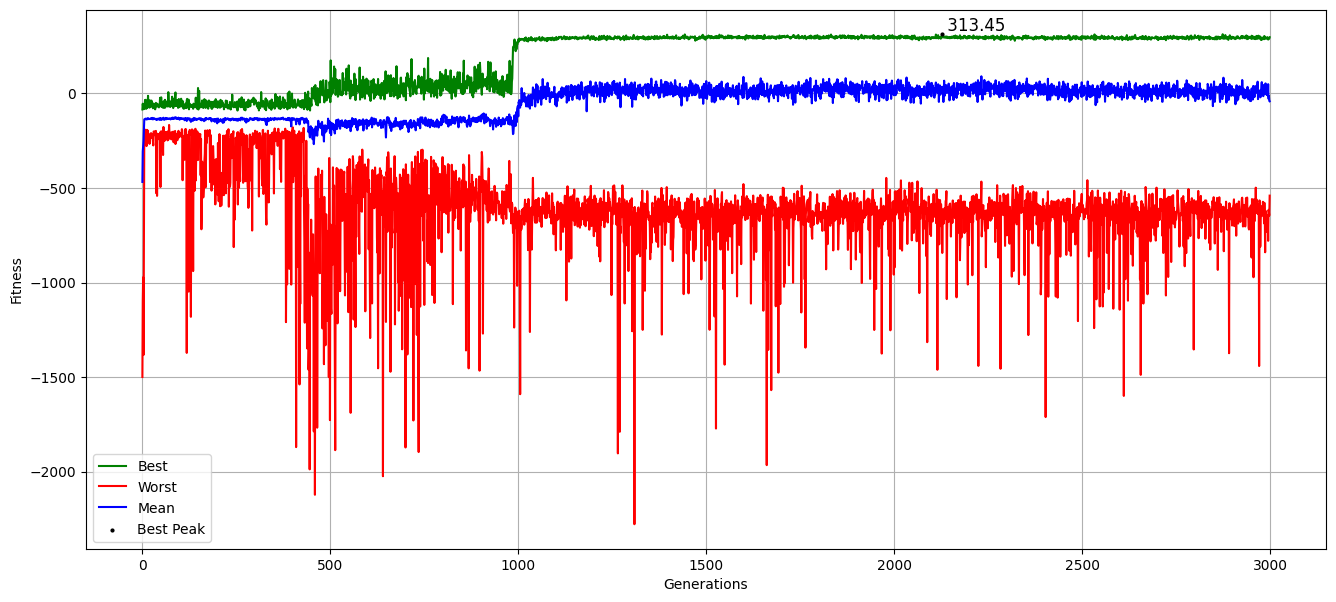

In [56]:
plt.figure(figsize=(16, 7))
plt.plot(best_fitness, color='green', label='Best')  # Línea verde
plt.plot(worst_fitness, color='red', label='Worst')  # Línea roja
plt.plot(mean_fitness, color='blue', label='Mean')  # Línea azul

# Encontrar el índice y el valor máximo de best_fitness
max_index = np.argmax(best_fitness)
max_value = best_fitness[max_index]

# Marcar el mejor fitness con un punto grande y una etiqueta
plt.scatter(max_index, max_value, color='black', s=4, zorder=3, label="Best Peak")
plt.text(max_index, max_value, f" {max_value:.2f}", fontsize=12, verticalalignment='bottom')

# Etiquetas y grid
plt.xlabel('Generations')
plt.ylabel('Fitness')
plt.grid()
plt.legend()
plt.show()

## Prueba del mejor individuo 🏆🚀

In [ ]:
env_test = gym.make("LunarLander-v3", render_mode="human")
model_test = MLP(LAYERS)
# model_test.from_chromosome(population[0])
model_test.from_chromosome(goat_ind)

def policy_test(observation, epsilon=0.1):
    if np.random.rand() < epsilon:  # 10% de las veces toma una acción aleatoria
        return np.random.randint(LAYERS[-1])
    return np.argmax(model_test.forward(observation))  # 90% de las veces usa el modelo individuo MLP

def run_test():
    """
    Esta función genera un escenario de juego y ejecuta la política definida en la función policy.
    Al acabar el juego (cuando se estrella o aterriza), devuelve la recompensa acumulada.
    """
    observation, info = env_test.reset() # se abre un escenario de juego
    racum = 0
    while True:
        action = policy_test(observation, epsilon=0.0)
        observation, reward, terminated, truncated, info = env_test.step(action)
        racum += reward
        if terminated or truncated:
            return racum

for e in range(10):
    print(f"Reward {e+1}: {run_test()}")
env_test.close()

Reward 1: 289.53580067739404
Reward 2: 251.02396344905722
Reward 3: 228.38692670557361
Reward 4: 301.66946102597024
Reward 5: 285.26818104894784
Reward 6: 273.3160943267103
Reward 7: 265.88827431353
Reward 8: 274.2191001983418
Reward 9: 263.7931743511804
Reward 10: 291.2577119235564


### Grabación de partidas 🎬

In [9]:
env_test = gym.make("LunarLander-v3", render_mode="rgb_array")
env_test = RecordVideo(env_test, "./lunarlander_videos", name_prefix="eval")
for episode_num in range(10):
    run_test()
print("Videos guardados en 'lunarlander_videos'")
env_test.close()

Videos guardados en 'lunarlander_videos'
